<a href="https://colab.research.google.com/github/sevvalcig123/sevval/blob/main/project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai import *

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
from fastai.vision import *

In [4]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 6.9MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [4]:
from fastai.vision.all import *

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = Path('/content/drive/MyDrive/animal')

In [7]:
pic = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.4, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

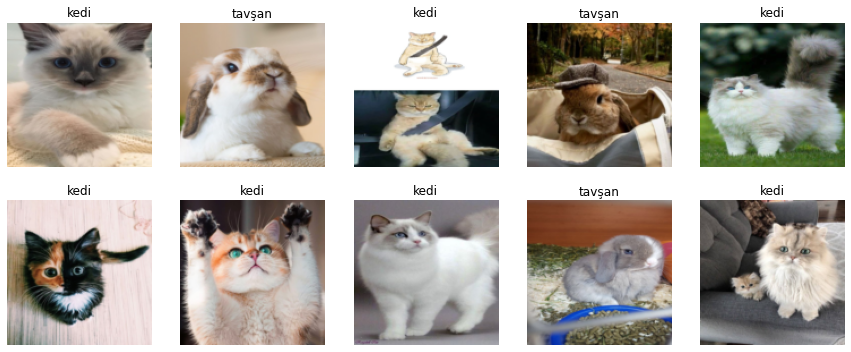

In [8]:
pic = pic.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = pic.dataloaders(path)
dls.valid.show_batch(max_n=10, nrows=2)

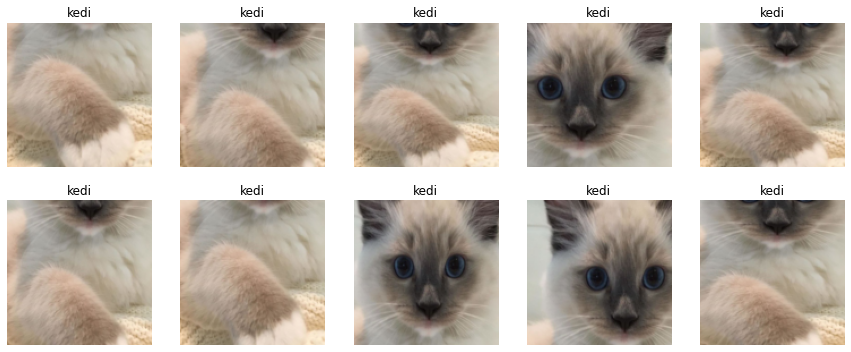

In [9]:
pic = pic.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = pic.dataloaders(path)
dls.train.show_batch(max_n=10, nrows=2, unique=True)

In [10]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.079649,1.030193,0.328358,02:11


epoch,train_loss,valid_loss,error_rate,time
0,0.664325,0.513307,0.261194,00:05
1,0.545605,0.460429,0.246269,00:05
2,0.451245,0.472574,0.246269,00:05
3,0.395830,0.523001,0.253731,00:05
4,0.342206,0.527848,0.268657,00:04
5,0.297938,0.507172,0.253731,00:05
6,0.259109,0.488213,0.253731,00:05
7,0.231237,0.463007,0.246269,00:05
8,0.207560,0.463469,0.238806,00:05
9,0.193288,0.469522,0.246269,00:05


In [11]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.062808,0.402151,0.171642,00:05
1,0.052389,0.366088,0.141791,00:05
2,0.065048,2.050722,0.365672,00:04
3,0.087086,0.796860,0.223881,00:05
4,0.089466,0.561389,0.179104,00:05
5,0.112979,0.517690,0.164179,00:05


In [12]:
learn.save('/content/drive/MyDrive/animal')

Path('/content/drive/MyDrive/animal.pth')

In [13]:
earn = cnn_learner(dls, resnet34, metrics=error_rate)

In [14]:
learn.unfreeze()

In [15]:
img = PILImage.create('/content/drive/MyDrive/animal/kedi/12.jpeg')
x, = first(dls.test_dl([img]))

In [16]:
class Hook():
 def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [17]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [18]:
with torch.no_grad(): output = learn.model.eval()(x)

In [19]:
act = hook_output.stored[0]

In [20]:
F.softmax(output, dim=-1)

tensor([[0.9981, 0.0019]], device='cuda:0')

In [21]:
dls.vocab

['kedi', 'tavşan']

In [22]:
x.shape

(1, 3, 128, 128)

In [23]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 4, 4])

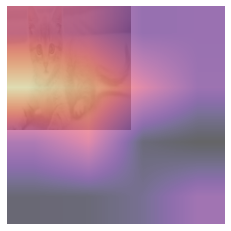

In [24]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
interpolation='bilinear', cmap='magma');

In [25]:
hook.remove()

In [26]:
class Hook():
  def __init__(self, m):
    self.hook = m.register_forward_hook(self.hook_func)
  def hook_func(self, m, i, o): self.stored = o.detach().clone()
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.hook.remove()

In [27]:
with Hook(learn.model[0]) as hook:
  with torch.no_grad(): output = learn.model.eval()(x.cuda())
  act = hook.stored

In [28]:
class HookBwd():
  def __init__(self, m):
    self.hook = m.register_backward_hook(self.hook_func)
  def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.hook.remove()

In [29]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
  with Hook(learn.model[0]) as hook:
    output = learn.model.eval()(x.cuda())
    act = hook.stored
  output[0,cls].backward()
  grad = hookg.stored

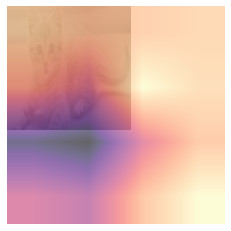

In [30]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
  interpolation='bilinear', cmap='magma');

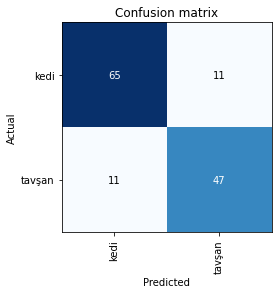

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

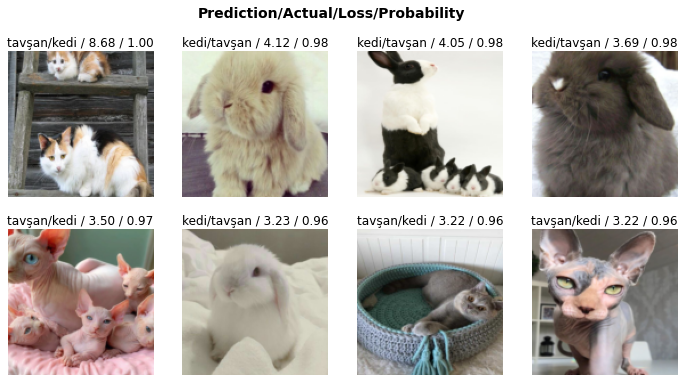

In [32]:
interp.plot_top_losses(8, nrows=2)

In [33]:
from fastai.vision.widgets import *

In [34]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [35]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [36]:
learn.export()

In [37]:
path = Path()
path.ls(file_exts=".pk1")

(#0) []

In [38]:
learn_inf = load_learner(path/'export.pkl')

In [39]:
learn_inf.dls.vocab

['kedi', 'tavşan']

In [40]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [42]:
img = PILImage.create(btn_upload.data[-1])

In [43]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [44]:
pred,pred_idx,probs = learn_inf.predict(img)

In [46]:
btn_run = widgets.Button(description = "classify")
btn_run

Button(description='classify', style=ButtonStyle())

In [47]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [48]:
btn_upload = widgets.FileUpload()

In [49]:
VBox([widgets.Label('Adopt your Pet'), 
      btn_upload, btn_run, out_pl])

In [50]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

     |████████████████████████████████| 2.5MB 8.5MB/s 
     |████████████████████████████████| 245kB 52.2MB/s 
     |████████████████████████████████| 112kB 54.0MB/s 
     |████████████████████████████████| 552kB 50.6MB/s 
     |████████████████████████████████| 430kB 51.9MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
